## Import Dependencies

In [29]:
import pandas as pd
import numpy as np

## Load Dataset

Movie Review

In [30]:
import os
from eraserbenchmark.rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

data_root = os.path.join('eraserbenchmark/data', 'movies')
documents = load_documents(data_root)
train, val, test = load_datasets(data_root)

In [31]:
data_raw = train[5]
data_raw.__dict__

{'annotation_id': 'negR_005.txt',
 'query': 'What is the sentiment of this review?',
 'evidences': frozenset({(Evidence(text='also unimpressive', docid='negR_005.txt', start_token=631, end_token=633, start_sentence=30, end_sentence=31),),
            (Evidence(text='it is a very bad mistake to make', docid='negR_005.txt', start_token=107, end_token=115, start_sentence=6, end_sentence=7),),
            (Evidence(text='sadly what follows is not really up to the buildup', docid='negR_005.txt', start_token=549, end_token=559, start_sentence=26, end_sentence=27),),
            (Evidence(text='tacky looking rundown martian mining colony', docid='negR_005.txt', start_token=405, end_token=411, start_sentence=19, end_sentence=20),),
            (Evidence(text='that still does not make for a really good science fiction experience', docid='negR_005.txt', start_token=218, end_token=230, start_sentence=11, end_sentence=12),),
            (Evidence(text='these are standard haunted house film shock e

In [32]:
import string
def obtain_text_review(data_raw, documents, token_length=256):
    word_list = [word for sent in documents[data_raw.annotation_id][:token_length] for word in sent+["\n"]][:token_length]
    word_list_refined = [" "+word if word not in string.punctuation else word for word in word_list ]
    paragraph = "".join(word_list_refined)[1:]
    return paragraph

from collections import Counter
data_split = train
token_length = 1000
label_types = {'POS':'positive', 'NEG':'negative'}

df = pd.DataFrame(columns=['review', 'label'])
for data_raw in data_split:
    review = obtain_text_review(data_raw, documents, token_length)
    label = data_raw.classification
    df.loc[len(df)] = [review, label_types[label]]

counts = df['label'].value_counts()
counts

negative    800
positive    800
Name: label, dtype: int64

## Get Explanations and SHAP score

### GPT explanation

In [33]:
# imports
import os
import ast  # for converting embeddings saved as strings back to arrays
import openai  
import pandas as pd
import tiktoken  # for counting tokens
from tqdm.auto import tqdm
from scipy import spatial  # for calculating vector similarities for search
openai.api_key = os.environ["OPENAI_API_KEY"]

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
# GPT_MODEL = "gpt-3.5-turbo-16k-0613"
GPT_MODEL = "gpt-4-0613" # According to OpenAI, GPT-4 is more responsive to system messages, whereas 3.5 would rely on more of the user input.


In [34]:
def summarize(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for x in input_premise:
            query.append(f">>>Review starts\n{x}\n>>>Review ends\n")
        query = "\n".join(query)
        n_reviews = len(input_premise)
    # Please shorten each of the following movie reivews in between 48-96 words in the tone of the reviewer while trying to preserve its meanings.

    sys_msg = f"""
    Please extract the opinions and rewrite the following movie reviews pretending you are the original reviewer, each in about 32 words. 
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review starts" and ">>>Review ends".

    Reply in the following format: 
    The response to each review contains 1 line, which is the shortened version of the review.
    If there are more than 2 reviews, the replies should be are serparated by a new line of "---".
    
    If you feel impossible to summary, please put "I can't summary this review" at the corresponding line.
    The followings are examples of valid replies:
    
    your summary 1
    ---
    I can't summary this review
    ---
    your summary 3
    """

    response = openai.ChatCompletion.create(
            messages=[
                {'role': 'system', 'content': sys_msg},
                {'role': 'user', 'content': query},
            ],
            model=GPT_MODEL,
            temperature=0,
        )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts+1 == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts+1} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError
    summarized_reviews = model_response.split("\n---\n")
    return summarized_reviews

summaries_list = []
batch_size = 5
sample_size = 120



new_df = df.sample(120).copy().reset_index(drop=True)
for i in tqdm(range(0, sample_size, batch_size)):
    summaries_list.extend(summarize(df.review[i:i+batch_size]))
new_df['review'] = summaries_list
new_df.to_csv(f'movies_{sample_size}.csv', index=False)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
np.random.choice(summaries_list, 10)

array(['"Love to Kill" is a crime film that attempts to blend humor and levity into the genre but ends up being a convoluted mess. The only redeeming aspect is the relationship between Tony Danza\'s character and the sister of a deceased woman. Danza\'s performance is impressive, but the film overall fails to deliver.',
       '"Species II" is a sequel that fails to improve upon its predecessor. Despite its potentially intriguing premise, the film is riddled with plot holes, ridiculous dialogue, and unconvincing special effects. The performances are lackluster, and the plot is often nonsensical.',
       '"Get Carter" is a disappointing action film, with Sylvester Stallone failing to recapture his 80\'s action hero glory. Despite strong performances from Mickey Rourke and Michael Caine, the film is let down by a weak script and poor casting.',
       '"Hard to Die" is a predictable, low-budget horror flick with a ridiculous storyline and poor acting. The special effects are unrealistic

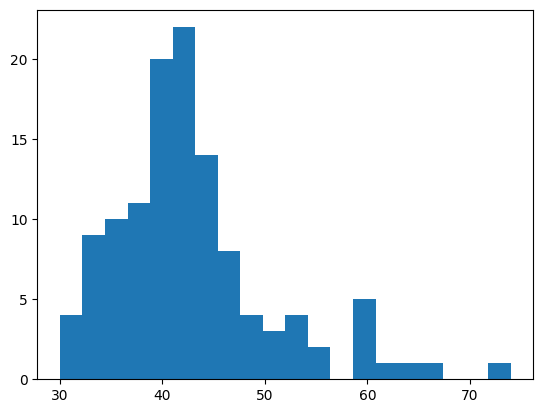

In [ ]:
wc = [len(x.split(' ')) for x in summaries_list]
import matplotlib.pyplot as plt
plt.hist(wc, bins=20)
plt.show()

In [ ]:
# an example nle question
choices = ['positive', 'negative']

def prediction_function(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for i, x in enumerate(input_premise):
            query.append(f">>>Review {i} starts\n{x}\n>>>Review {i} ends\n")
        query = "".join(query)
        n_reviews = len(input_premise)
    # print(query)
    sys_msg = f"""
    What is the sentiment of the following reviews?
    For each review, provide the probabilities of each choices from {choices} and explain your reasoning.
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review i starts" and ">>>Review i ends" where i is the number. The notion "[MASK]" means a missing word.

    Reply in the following format: 
    The reply to each review contains 3 lines.
    The first line contains the probabilities of each choice seperated by a space,
    and the second line is the explanation, which should not contain any special character.
    The third line is a seperator "---" marking the end of the reply.
    There should be no new line between consecutive replies.
    
    If you cannot decide, please still guess a probability for each choice and explain why you cannot decide.
    The followings are examples of a valid response that contains 4 replies, followed by 4 lines of "---":
    0.15 0.85
    your explanation
    ---
    0.5 0.5
    your explanation
    ---
    0.68 0.32
    your explanation
    ---
    0.71 0.29
    your explanation
    ---
    """

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': sys_msg},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0,
    )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError

    y_prob_list, model_nle_list = [], []
    model_response += '\n'
    for line in model_response.split("\n---\n")[:-1]:
        try:
            y_prob, model_nle = line.split('\n')
            y_prob = [float(p) for p in y_prob.split(' ')]
            y_prob_list.append(y_prob)
            model_nle_list.append(model_nle)
        except:
            print(">>>>>>>>>>>>Exception: model reply in wrong format for one reply")
            print(query)
            print(model_response)
            # y_prob_list.append([0.5, 0.5])
            # model_nle_list.append("Unknown")
            raise AssertionError
    return y_prob_list, model_nle_list

# SHAP_function("I love this movie, but I don't like the ending. Still it is a good movie.")
# SHAP_function("I ? this movie, but I don't ? the ending. Still it is a ? movie.")
# SHAP_function(df.review[5])
import scipy as sp
import time
import requests

current_request_count = 0
current_token_count = 0
def f(x, batch_size=10):
    outputs = []
    for i in range(0,len(x),batch_size):
        _x = x[i:i+batch_size]
        success = False
        n_trials = 5
        while n_trials > 0:
            try:
                if time.time() - globals()['current_time'] < 10 and globals()['current_request_count'] > 32:
                    print('request hits limit')
                    time.sleep(5)
                    globals()['current_time'] = time.time()
                    globals()['current_request_count'] = 0
                y_prob_list, _ = prediction_function(_x)
                time.sleep(5)
                globals()['current_request_count'] += 1
                success = True
                break
            except AssertionError:
                print("retrying")
                n_trials -= 1
                continue
            except TimeoutError or requests.exceptions.Timeout or requests.exceptions.readTimeout or socket.timeout:
                print("time out and sleep")
                time.sleep(60)
                continue
        if success == False:
            raise AssertionError("model reply in wrong format")
        outputs.extend(y_prob_list)
    outputs = np.array(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val


import tiktoken
import shap
from functools import partial
from tqdm.auto import tqdm

class tokenizer:
    def __init__(self) -> None:
        self.tokenizer = tiktoken.encoding_for_model(GPT_MODEL)
    def __call__(self, x):
        return {"input_ids":self.tokenizer.encode(x)}
    def decode(self, x):
        return self.tokenizer.decode(x)

tok = tokenizer()
shap_tok = shap.maskers.Text(tok, mask_token='[MASK]', collapse_mask_token=False)

sample_df = pd.read_csv('movies_120.csv')
sample_df['shap_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'] = [np.zeros(1).astype('object')]*len(sample_df)
sample_df['shap_base_values'].astype('object')
sample_df['shap_data'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['y_prob'] =[np.zeros(1).astype('object')]*len(sample_df)
sample_df['model_nle'] =[np.zeros(1).astype('object')]*len(sample_df)

start_i = 47
if start_i >= 1:
    sample_df = pd.read_csv(f'movies_120_shap_{start_i-1}.csv')

import socket
current_time = time.time()
for i in tqdm(range(start_i,len(sample_df))):
    time.sleep(60)
    current_review_summary = sample_df.review[i]
    explainer = shap.Explainer(partial(f, batch_size=8), masker=shap_tok, output_names=choices)
    y_prob, model_nle = prediction_function([current_review_summary])
    # shap_values = explainer([current_review_summary], max_evals=64)
    shap_values = explainer([current_review_summary], batch_size=8, max_evals=128)
    sample_df.loc[i, 'shap_values'] = shap_values.values.tolist()
    sample_df.loc[i, 'shap_base_values'] = np.array([shap_values.base_values]).tolist()
    sample_df.loc[i, 'shap_data'] = np.array([shap_values.data]).tolist()
    sample_df.loc[i, 'y_prob'] = np.array([y_prob]).tolist()
    sample_df.loc[i, 'model_nle'] = np.array(model_nle).astype('object')
    sample_df.to_csv(f'movies_120_shap_{i}.csv', index=False)
    print(f"finish review {i+1} \r") 

# f(["This book is pretty interesting but it's too long", "This book is pretty interesting but it's too [MASK]"])

## Visualize resulted SHAP data

In [ ]:
import ast
some_df = pd.read_csv('movies_120_shap_119.csv')
def get_literal_eval(x):
    x = np.array(ast.literal_eval(x)).astype('object')
    return x

some_df.shap_values = some_df.shap_values.apply(get_literal_eval)
some_df.shap_base_values = some_df.shap_base_values.apply(get_literal_eval)
some_df.shap_data = some_df.shap_data.apply(get_literal_eval)


In [ ]:
import shap

idx = 9
shap_values = shap.Explanation(sample_df.shap_values[idx], sample_df.shap_base_values[idx], sample_df.shap_data[idx]) 

shap.plots.text(shap_values, grouping_threshold=0.005)

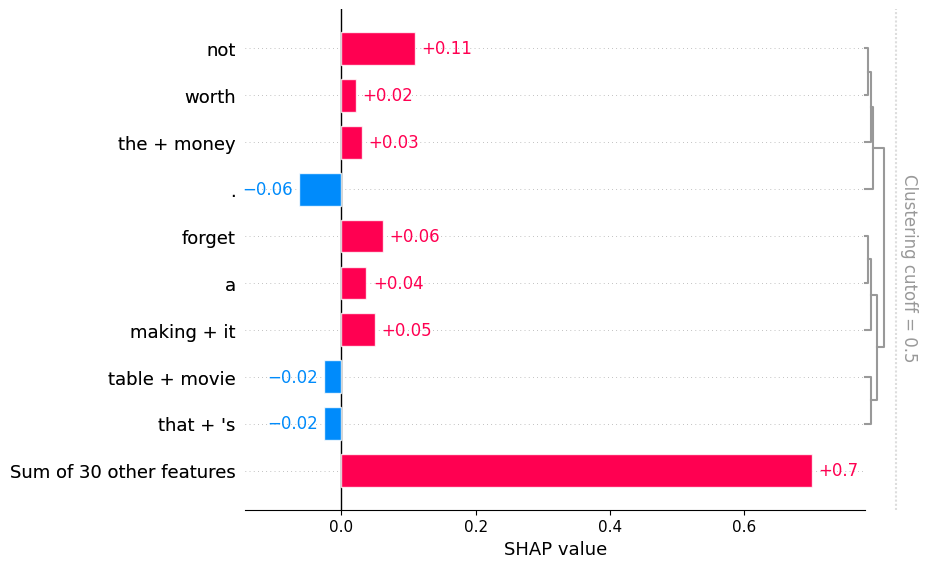

In [16]:
shap.plots.bar(shap_values[0,:,'negative'], clustering_cutoff=0.5)